In [5]:
# import all libraries you need here
import pandas as pd
import numpy as np
import pathlib as pl
import harmonypy as hm


import scanpy as sc

In [6]:
random_seed = 42
np.random.seed(random_seed)
sc.settings.seed = random_seed

# Step 0: Load the data

In [7]:
path_data_train = pl.Path("data/train_data")
path_data_test = pl.Path("data/test_data")

In [8]:
train_bulk = pd.read_csv(path_data_train / "train_bulk.csv",index_col=0)
train_bulk_trueprops = pd.read_csv(path_data_train / "train_bulk_trueprops.csv",index_col=0)
train_adata = sc.read_h5ad(path_data_train / "train_adata.h5ad")
test_adata = sc.read_h5ad(path_data_test / "test_adata.h5ad")
test_bulk = pd.read_csv(path_data_test / "test_bulk.csv",index_col=0)


In [9]:
print(f"Number of patients to deconvolve: {train_bulk.shape[1]}")
print(f"Number of genes in dataset: {train_bulk.shape[0]}")

Number of patients to deconvolve: 12
Number of genes in dataset: 7725


In [10]:
print(train_adata.obs.shape)
train_adata.obs.head()

(32374, 10)


,Sample,Patient,Tumor status,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,highLevelType,chemo
AAACCCAAGGAGACCT-1_1,s1,P1,Tumor,991,991,2156.0,131.0,6.076067,T,post
AAACCCAGTAGACAGC-1_1,s1,P1,Tumor,1063,1063,2485.0,84.0,3.380282,T,post
AAACCCAGTAGATCGG-1_1,s1,P1,Tumor,855,855,1993.0,87.0,4.365278,T,post
AAACCCAGTATCACCA-1_1,s1,P1,Tumor,1002,1002,2147.0,139.0,6.474150,B,post
AAACCCAGTTGGAGGT-1_1,s1,P1,Tumor,958,958,2438.0,108.0,4.429861,T,post


In [11]:
print(train_adata.var.shape)
train_adata.var.head()

(7725, 6)


,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Unnamed: 0,,,,,,
NOC2L,6735,False,6735,0.143681,87.143757,7527.0
HES4,8287,False,8287,0.330635,84.181190,17321.0
ISG15,19640,False,19640,0.871934,62.509783,45678.0
TNFRSF18,12021,False,12021,0.682345,77.053467,35746.0
TNFRSF4,7880,False,7880,0.484510,84.958100,25382.0


In [12]:
print(train_bulk.shape)
train_bulk.head()

(7725, 12)


,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
Unnamed: 0,,,,,,,,,,,,
NOC2L,201.0,226.0,133.0,150.0,167.0,176.0,235.0,190.0,147.0,123.0,143.0,132.0
HES4,470.0,532.0,874.0,924.0,332.0,352.0,661.0,463.0,432.0,349.0,333.0,363.0
ISG15,852.0,918.0,1995.0,2116.0,1221.0,1282.0,1649.0,1152.0,957.0,847.0,717.0,768.0
TNFRSF18,712.0,870.0,1753.0,1925.0,352.0,289.0,2069.0,1357.0,446.0,367.0,821.0,844.0
TNFRSF4,550.0,472.0,920.0,1207.0,211.0,240.0,940.0,943.0,310.0,278.0,655.0,834.0


In [13]:
print(f"Number of cells in the train set {train_adata.n_obs}")
for spl in train_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {train_adata[train_adata.obs.Sample==spl].n_obs}")

Number of cells in the train set 32374
Number of cells for s1 is 6821
Number of cells for s2 is 4555
Number of cells for s3 is 5166
Number of cells for s4 is 5607
Number of cells for s7 is 4471
Number of cells for s8 is 5754


In [14]:
print(f"There are {train_adata.obs.highLevelType.nunique()} different cell types in the dataset")
print(f"The different cells types are {train_adata.obs.highLevelType.unique().astype(str)}")

There are 9 different cell types in the dataset
The different cells types are ['T' 'B' 'Plasmablast' 'Fibroblast' 'Mast' 'Myeloid' 'NK' 'Myofibroblast'
 'Endothelial']


In [15]:
print(f"Number of cells in the test set {test_adata.n_obs}")
for spl in test_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {test_adata[test_adata.obs.Sample==spl].n_obs}")

Number of cells in the test set 18616
Number of cells for s5 is 6020
Number of cells for s6 is 5530
Number of cells for s9 is 3336
Number of cells for s10 is 3730


In [16]:
train_bulk.head()

,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
Unnamed: 0,,,,,,,,,,,,
NOC2L,201.0,226.0,133.0,150.0,167.0,176.0,235.0,190.0,147.0,123.0,143.0,132.0
HES4,470.0,532.0,874.0,924.0,332.0,352.0,661.0,463.0,432.0,349.0,333.0,363.0
ISG15,852.0,918.0,1995.0,2116.0,1221.0,1282.0,1649.0,1152.0,957.0,847.0,717.0,768.0
TNFRSF18,712.0,870.0,1753.0,1925.0,352.0,289.0,2069.0,1357.0,446.0,367.0,821.0,844.0
TNFRSF4,550.0,472.0,920.0,1207.0,211.0,240.0,940.0,943.0,310.0,278.0,655.0,834.0


# Step 1: Deconvolve the data

## Deconvolution Methods Overview

We're using **Support Vector Regression (SVR)** for cell type deconvolution, the same approach as **CIBERSORT**. This method:

1. **Creates a reference matrix**: Average gene expression for each cell type from single-cell data
2. **Standardizes data**: Uses StandardScaler to normalize gene expression across samples
3. **Applies SVR**: Uses nu-SVR with linear kernel to solve the deconvolution problem
4. **Solves**: `bulk = reference × proportions` where proportions are non-negative and sum to 1
5. **Advantages**: More robust to outliers than NNLS, better handles complex relationships

### Key SVR Parameters:
- **nu**: Controls the number of support vectors (0.5 is default, range 0-1)
- **kernel**: 'linear' (recommended for deconvolution), 'rbf', or 'poly'
- **C**: Regularization parameter (1.0 default)

### Alternative methods you could try:

- **NNLS**: Simple non-negative least squares (faster but less robust)
- **MuSiC**: Multi-subject single-cell deconvolution (accounts for cross-sample variation)
- **Scaden**: Deep learning approach (requires more training data)
- **Bisque**: Reference-based decomposition with marker gene selection
- **CellMix**: Comprehensive deconvolution framework

### Tips for better results:
- Filter to highly variable genes or marker genes
- Standardize data (already done in SVR approach)
- Use cross-validation to optimize nu and kernel parameters
- Try different kernels: 'linear' for simpler relationships, 'rbf' for non-linear


In [65]:
from sklearn.svm import NuSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
# import warnings
# warnings.filterwarnings('ignore')

CELL_ORDER = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast', 'NK', 'Myeloid', 'Mast']  

# OPTIONAL: Improved deconvolution with marker gene selection
def select_marker_genes(adata, n_genes=500, method='variance'):
    """
    Select marker genes for deconvolution.
    
    Parameters:
    - adata: AnnData object with single-cell data
    - n_genes: Number of marker genes to select
    - method: 'variance' for highly variable genes, or 'differential' for DE genes
    """
    if method == 'variance':
        # Select highly variable genes
        sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat_v3')
        marker_genes = adata.var_names[adata.var.highly_variable]
    elif method == 'differential':
        # Find marker genes using differential expression
        # This requires computing for each cell type
        sc.tl.rank_genes_groups(adata, groupby='highLevelType', method='wilcoxon')
        # Get top markers for each cell type
        marker_genes = []
        for ct in adata.obs.highLevelType.unique():
            markers = sc.get.rank_genes_groups_df(adata, group=ct).head(n_genes // 9)
            marker_genes.extend(markers['names'].tolist())
        marker_genes = list(set(marker_genes))  # Remove duplicates
    
    return marker_genes


def cibersort_svr(bulk_sample, reference_matrix, nu=0.5, kernel='linear'):
    # model = GridSearchCV(NuSVR(nu=nu, kernel=kernel, max_iter=-1, shrinking=True), cv=5, param_grid={"nu": [0.25, 0.5, 0.75]}, scoring="neg_mean_squared_error", refit=True)
    # model.fit(reference_matrix, bulk_sample)
    # nu = model.best_params_['nu']
    # print(f"Best nu: {nu}")

    model = NuSVR(nu=nu, kernel=kernel, shrinking=True, max_iter=-1)
    model.fit(reference_matrix, bulk_sample)
    print(f"SVR fitted.")

    weights = np.array(model.coef_)[0]
    weights = np.clip(weights, 0, None)  # Ensure non-negative
    weights = weights / weights.sum()  # Normalize to sum to 1
    return weights


# Step 1: Create reference matrix (average expression per cell type)
def create_reference_matrix(adata, cell_type_col='highLevelType'):
    """
    Create a reference gene expression matrix from single-cell data.
    Each column represents average expression for one cell type.
    """
    cell_types = sorted(adata.obs[cell_type_col].unique())
    reference = pd.DataFrame(
        index=adata.var_names,
        columns=cell_types
    )
    
    for ct in cell_types:
        # Get cells of this type
        mask = adata.obs[cell_type_col] == ct
        # Calculate mean expression
        reference[ct] = adata[mask].X.mean(axis=0).A1  # .A1 converts matrix to 1D array
    
    return reference

# Step 2: Deconvolve using SVR (CIBERSORT approach)
def deconvolve_svr(bulk_data, reference_matrix, nu=0.5, kernel='linear'):
    """
    Deconvolve bulk RNA-seq data using Support Vector Regression (CIBERSORT approach).
    
    Parameters:
    - bulk_data: DataFrame with genes as rows, samples as columns
    - reference_matrix: DataFrame with genes as rows, cell types as columns
    - nu: Nu parameter for nu-SVR (controls number of support vectors)
    - kernel: Kernel type for SVR ('linear', 'rbf', 'poly')
    
    Returns:
    - DataFrame with cell types as rows, samples as columns (proportions)
    """
    # Find common genes
    common_genes = bulk_data.index.intersection(reference_matrix.index)
    print(f"Using {len(common_genes)} common genes for deconvolution")
    
    # Subset to common genes
    bulk_subset = bulk_data.loc[common_genes]
    ref_subset = reference_matrix.loc[common_genes]
    
    # Standardize the data (important for SVR)
    scaler_ref = StandardScaler()
    scaler_bulk = StandardScaler()
    
    ref_scaled = scaler_ref.fit_transform(ref_subset.T).T  # Scale across genes
    bulk_scaled = scaler_bulk.fit_transform(bulk_subset.T).T
    
    # Initialize results
    proportions = pd.DataFrame(
        index=ref_subset.columns,  # cell types
        columns=bulk_subset.columns  # samples
    )
    
    # Deconvolve each sample
    for sample in bulk_subset.columns:
        # Get bulk profile for this sample
        bulk_profile = bulk_scaled[:, bulk_subset.columns.get_loc(sample)]
        
        # Use nu-SVR with constraints to get non-negative proportions
        # We'll solve for each cell type proportion
        props = cibersort_svr(bulk_profile, ref_scaled, nu=nu, kernel=kernel)        
        
        proportions[sample] = props
    
    return proportions.loc[CELL_ORDER]

# Create reference from training data
print("Creating reference matrix from single-cell data...")
reference = create_reference_matrix(train_adata, cell_type_col='highLevelType')
print(f"Reference shape: {reference.shape}")
print(f"Cell types: {list(reference.columns)}")

adata_copy = train_adata.copy()
marker_genes = select_marker_genes(adata_copy, n_genes=1000)
print(f"Selected {len(marker_genes)} marker genes")
reference_markers = reference.copy()
reference_markers = reference_markers.loc[marker_genes]

# Deconvolve training bulk data using SVR (CIBERSORT approach)
print("\nDeconvolving training bulk data with SVR...")
train_props_pred = deconvolve_svr(train_bulk, reference_markers, nu=0.5, kernel='linear')
print(f"Predicted proportions shape: {train_props_pred.shape}")
print("\nFirst few predictions:")
print(train_props_pred.iloc[:, :3])

# Compare with true proportions
print("\nTrue proportions (first few samples):")
print(train_bulk_trueprops.iloc[:, :3])

Creating reference matrix from single-cell data...
Reference shape: (7725, 9)
Cell types: ['B', 'Endothelial', 'Fibroblast', 'Mast', 'Myeloid', 'Myofibroblast', 'NK', 'Plasmablast', 'T']
Reference shape: (7725, 9)
Cell types: ['B', 'Endothelial', 'Fibroblast', 'Mast', 'Myeloid', 'Myofibroblast', 'NK', 'Plasmablast', 'T']
Selected 1000 marker genes

Deconvolving training bulk data with SVR...
Using 1000 common genes for deconvolution
Selected 1000 marker genes

Deconvolving training bulk data with SVR...
Using 1000 common genes for deconvolution
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
SVR fitted.
Predicted proportions shape: (9, 12)

First few predictions:
                   s1_0      s1_1      s2_0
T              0.144089  0.000000  0.000000
Endothelial    0.064343  0.025325  0

Evaluation on training data:
Mean Absolute Error (MAE): 0.1400
Root Mean Squared Error (RMSE): 0.2163
Task Benchmark Score (TB): 0.1993

Per-cell-type MAE:
  T: 0.3798
  Fibroblast: 0.1462
  NK: 0.1398
  Myeloid: 0.0879
  Mast: 0.0787
  B: 0.1155
  Myofibroblast: 0.1307
  Endothelial: 0.1048
  Plasmablast: 0.0762


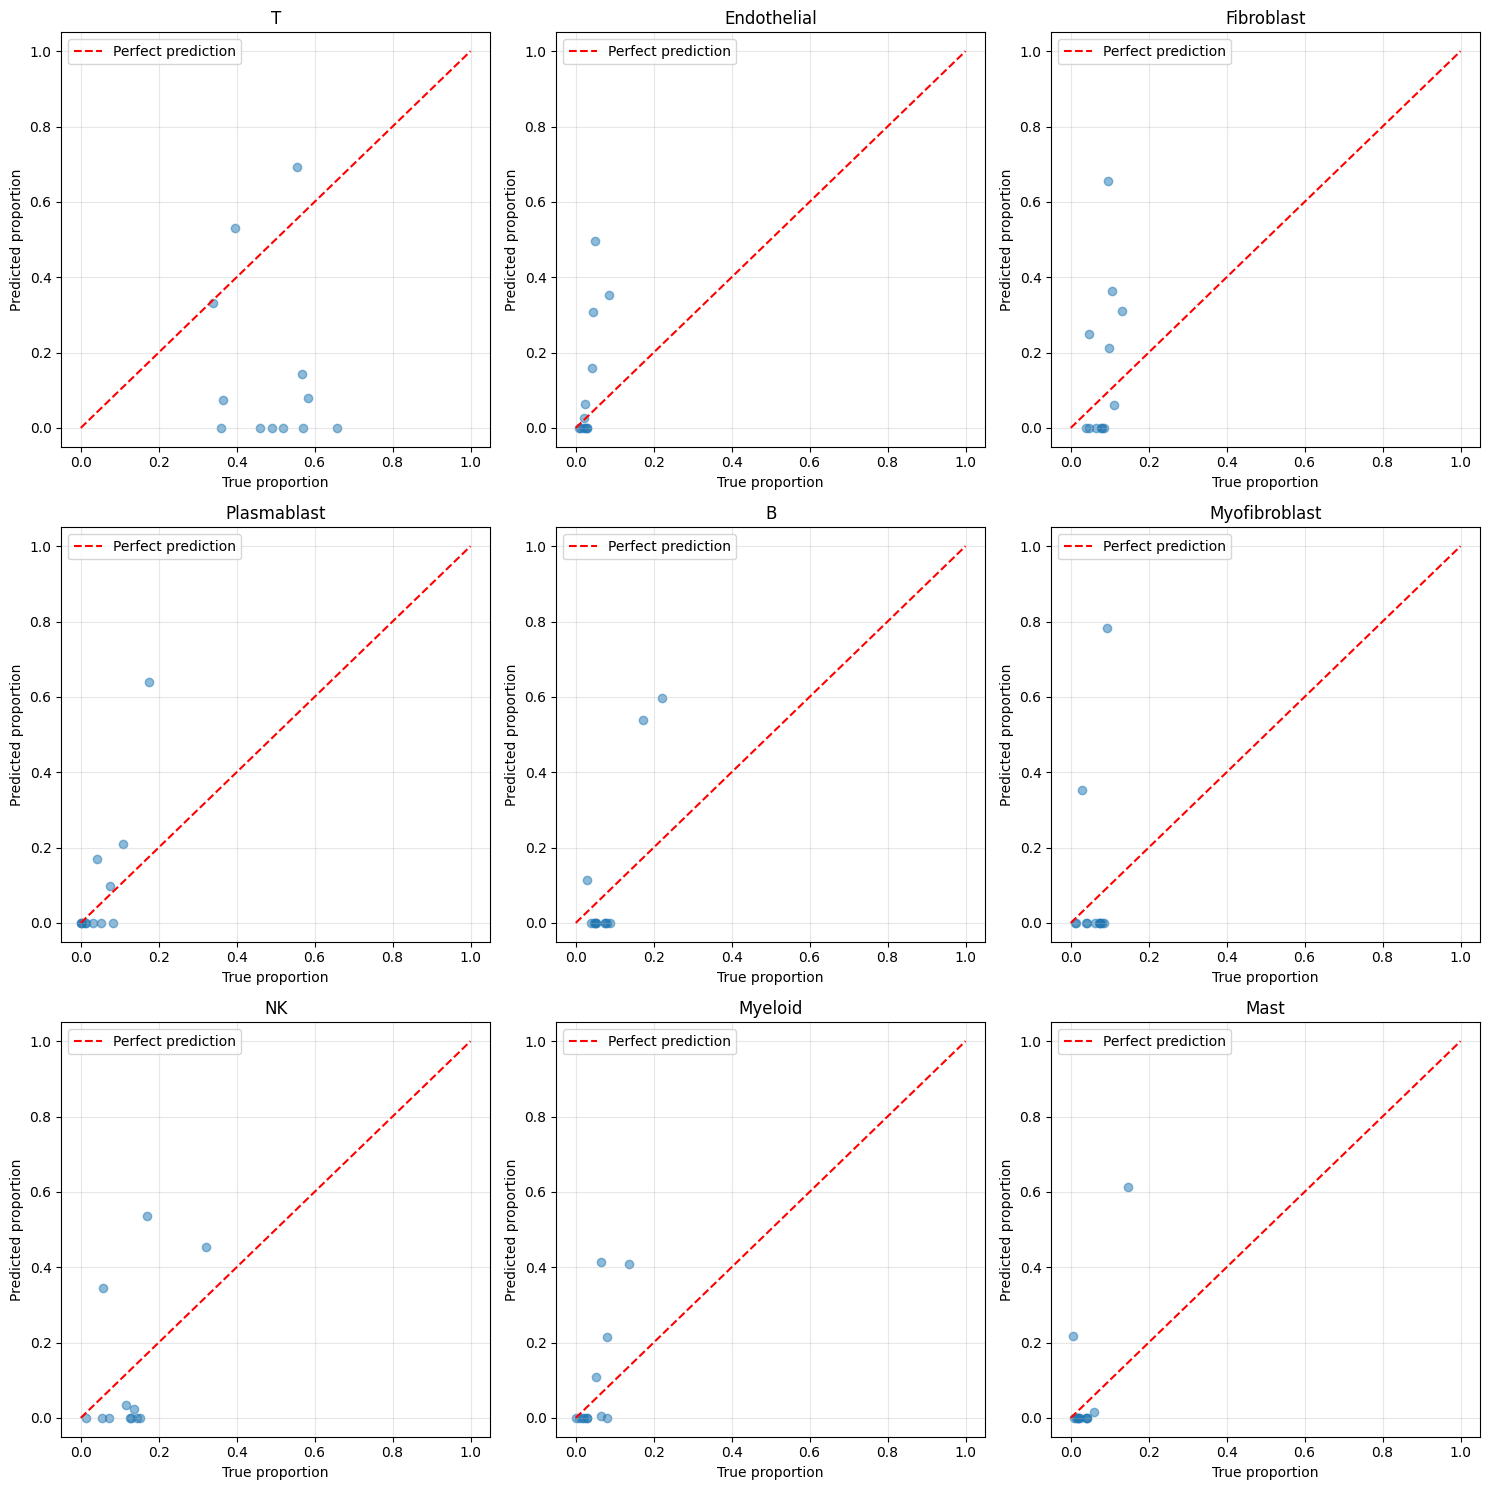

In [66]:
# Evaluate performance on training data
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def task_benchmark_score(true_props: pd.DataFrame, pred_props: pd.DataFrame):
    mae = (true_props.values - pred_props.values) ** 2
    return np.sqrt(mae.mean(axis=1)).mean()

def evaluate_deconvolution(true_props, pred_props):
    """Calculate performance metrics for deconvolution"""
    # Ensure same ordesr
    common_samples = true_props.columns.intersection(pred_props.columns)
    common_celltypes = true_props.index.intersection(pred_props.index)
    
    true = true_props.loc[common_celltypes, common_samples]
    pred = pred_props.loc[common_celltypes, common_samples]
    
    mse = mean_squared_error(true.values.flatten(), pred.values.flatten())
    mae = mean_absolute_error(true.values.flatten(), pred.values.flatten())
    tb = task_benchmark_score(true, pred)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Task Benchmark Score (TB): {tb:.4f}")
    
    # Per cell type performance
    print("\nPer-cell-type MAE:")
    for ct in common_celltypes:
        ct_mae = mean_absolute_error(true.loc[ct], pred.loc[ct])
        print(f"  {ct}: {ct_mae:.4f}")
    
    return mae, rmse

print("Evaluation on training data:")
evaluate_deconvolution(train_bulk_trueprops, train_props_pred)

# Visualize predictions vs true
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, ct in enumerate(train_props_pred.index):
    ax = axes[idx]
    ax.scatter(train_bulk_trueprops.loc[ct], train_props_pred.loc[ct], alpha=0.5)
    ax.plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
    ax.set_xlabel('True proportion')
    ax.set_ylabel('Predicted proportion')
    ax.set_title(f'{ct}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Deconvolve test bulk data using SVR
print("Deconvolving test bulk data with SVR...")
test_props_pred = deconvolve_svr(test_bulk, reference, nu=0.5, kernel='linear')
print(f"Test proportions shape: {test_props_pred.shape}")
test_props_pred = test_props_pred.reset_index()
print("\nTest predictions (first few samples):")
test_props_pred.iloc[:, :].head()



Deconvolving test bulk data...
Using 7725 common genes for deconvolution
Test proportions shape: (9, 20)

Test predictions (first few samples):


,index,s5_0,s5_1,s5_2,s5_3,s5_4,s6_0,s6_1,s6_2,s6_3,...,s9_0,s9_1,s9_2,s9_3,s9_4,s10_0,s10_1,s10_2,s10_3,s10_4
0,T,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Endothelial,0.054111,0.077470,0.085663,0.075040,0.107382,0.062465,0.029951,0.056923,0.064198,...,0.014504,0.090497,0.030299,0.158531,0.011653,0.000000,0.002007,0.000000,0.000000,0.000000
2,Fibroblast,0.028673,0.021569,0.000000,0.024507,0.008515,0.037537,0.096298,0.084217,0.059025,...,0.091597,0.021978,0.074637,0.071339,0.136521,0.088722,0.079575,0.035576,0.082278,0.047404
3,Plasmablast,0.038639,0.002045,0.020062,0.011864,0.007884,0.000000,0.000000,0.000000,0.000000,...,0.002067,0.000000,0.001166,0.003711,0.002231,0.000000,0.000000,0.002044,0.011193,0.000000
4,B,0.294386,0.328511,0.211260,0.276015,0.249851,0.463094,0.451851,0.434084,0.475777,...,0.746195,0.642952,0.690765,0.659648,0.732414,0.636033,0.565168,0.605385,0.579677,0.676546


### Optional: Improved deconvolution with marker gene selection

For better results, you can select marker genes (highly variable or differentially expressed):


# Step 2: Perform clustering 

In [21]:
# Preprocessing
def sc_preprocess(sc_data):
    #sc.pp.filter_cells(sc_data, min_genes=200)
    sc.pp.filter_genes(sc_data, min_cells=3)
    #sc_data = sc_data[sc_data.obs['pct_counts_mt'] < 10]

    sc.pp.normalize_total(sc_data, target_sum=1e4)
    sc.pp.log1p(sc_data)

    sc.pp.highly_variable_genes(sc_data, n_top_genes=2000, batch_key="Sample")
    sc_data = sc_data[:, sc_data.var['highly_variable']]

    sc.pp.scale(sc_data, max_value=10)
    return sc_data

In [22]:
# PCA and batch correction with Harmony
def sc_batch_norm(sc_data):
    sc.tl.pca(sc_data, svd_solver='arpack')
    ho = hm.run_harmony(sc_data.obsm['X_pca'], sc_data.obs, 'Sample')
    sc_data.obsm['X_pca_harmony'] = ho.Z_corr.T
    return sc_data

In [23]:
def sc_cluster(sc_data):   
    sc.pp.neighbors(sc_data, use_rep='X_pca_harmony')
    sc.tl.leiden(sc_data, resolution=0.5)
    return sc_data

In [24]:
def sc_umap(sc_data):
    sc.tl.umap(sc_data, min_dist=0.3)
    sc.pl.umap(sc_data, color=['Sample', 'leiden'])

# Step 2bis: Predict on the test data

In [25]:
# SC pipeline
sc.pp.filter_genes(test_adata, min_cells=3)
sc.pp.normalize_total(test_adata, target_sum=1e4)
sc.pp.log1p(test_adata)
sc.pp.highly_variable_genes(test_adata, n_top_genes=2000, batch_key="Sample")
test_adata = test_adata[:, test_adata.var['highly_variable']]
sc.pp.scale(test_adata, max_value=10)

sc.tl.pca(test_adata, svd_solver='arpack')

ho = hm.run_harmony(test_adata.obsm['X_pca'], test_adata.obs, 'Sample')

test_adata.obsm['X_pca_harmony'] = ho.Z_corr.T

sc.pp.neighbors(test_adata, use_rep='X_pca_harmony')

sc.tl.leiden(test_adata, resolution=0.5)

/home/plaf/Documents/Scuola/ETH/master/3sem/ml4g/Genomics_2/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/plaf/.local/share/uv/python/cpython-3.12.12-linux-x86_64-gnu/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-11-21 12:07:35,727 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-21 12:07:42,903 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-21 12:07:43,488 - harmonypy - INFO - Iteration 1 of 10
2025-11-21 12:07:56,778 - harmonypy - INFO - Iteration 2 of 10
2025-11-21 12:08:09,730 - harmonypy - INFO - Iteration 3 of 10
2025-11-21 12:08:24,177 - harmonypy - INFO - Iteration 4 of 10
2025-11-21 12:08:45,103 - harmonypy - INFO - Iteration 5 of 10
2025-11-21 12:09:00,221 - harmonypy - INFO - Converged after 5 iterations
/h

In [26]:
cluster_labels = test_adata.obs
cluster_labels = cluster_labels.reset_index()
cluster_labels = cluster_labels[['index', 'leiden']]
cluster_labels.rename(columns={'leiden': 'cluster'}, inplace=True)

# Step 3: Save the required files

In [27]:
assert len(test_props_pred.columns) == len(test_bulk.columns) + 1, "Length mismatch: expected {} but got {}".format(len(test_bulk.columns) + 1, len(test_props_pred.columns))
assert all(test_props_pred.columns == np.append(["index"], test_bulk.columns)), "Wrong columns"

In [28]:
assert all(test_props_pred['index']== ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast']), "Wrong order for cell types"

In [29]:
assert all(test_props_pred.drop("index",axis=1).sum().round()==1), "The proportions for a single patient must sum to 1"

In [30]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = test_adata.columns

In [31]:
assert all(cluster_labels.columns == ["index", "cluster"]), "Wrong columns"

In [32]:
assert all(cluster_labels["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [35]:
import zipfile
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

from os import environ

first_name = environ.get('FIRST_NAME')
last_name = environ.get('LAST_NAME')
tstamp = datetime.now().strftime("%Y%m%d_%H%M%S")

results_path = pl.Path("data/submissions/")
archive_name = f"{tstamp}_{first_name}_{last_name}_Project2_submission.zip"

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        test_props_pred.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    zf.close()

print(f"Submission archive saved to {results_path / archive_name}")

archive_name = f"{tstamp}_{first_name}_{last_name}_Project2_code.zip"

files_mapping = {
    "main.ipynb": "main.ipynb",
    "uv.lock": "uv.lock",
    ".python-version": ".python-version",
    "pyproject.toml": "pyproject.toml",
}

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    for fname, arcname in files_mapping.items():
        zf.write(fname, arcname)
    zf.close()

print(f"Code archive saved to {results_path / archive_name}")


Submission file saved to data/submissions/20251121_121833_Paolo_Laffranchi_Project2_submission.zip
